In [1]:
from utils import tflog2pandas, find_files
import glob
import shutil
from sklearn.preprocessing import LabelEncoder
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path_to_logs = './output/logs'
fucked_up_logs_dir = "./temp-logdir/"
logs = find_files(path_to_logs, "events.out")

In [3]:
all_dataframes = []
all_params = []
for log in logs:
    df = tflog2pandas(log) 
    params_filename = "/".join(log.split("/")[:-1]) + "/training-params-custom.txt"
    with open(params_filename, "r+") as f:
        params = eval(f.read())
        
    model_name = log.split("/")[-2]
    df['model_name'] = model_name
    params['model_name'] = model_name
    all_dataframes.append(df)
    all_params.append(params)

#print(all_params)    

result_df = pd.concat(all_dataframes, ignore_index=True)
params_df = pd.DataFrame(all_params)

merged_df = pd.merge(result_df, params_df, on='model_name')
merged_df.rename(columns={'optim': 'optimizer', 
                         'per_device_train_batch_size': 'batch_size', 
                         'gradient_accumulation_steps': 'accumulation_steps'}, inplace=True)

df = merged_df[['metric', 'value', 'step', 'optimizer', 'accumulation_steps', 'batch_size' ]]


In [4]:
print(df.info(), df.columns, df.shape, df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15792 entries, 0 to 15791
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   metric              15792 non-null  object 
 1   value               15792 non-null  float64
 2   step                15792 non-null  float64
 3   optimizer           15792 non-null  object 
 4   accumulation_steps  15792 non-null  int64  
 5   batch_size          15792 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 740.4+ KB
None Index(['metric', 'value', 'step', 'optimizer', 'accumulation_steps',
       'batch_size'],
      dtype='object') (15792, 6)                                metric         value    step  \
0                          train/loss  1.762100e+00    10.0   
1                          train/loss  1.417900e+00    20.0   
2                          train/loss  1.176100e+00    30.0   
3                          train/loss  9.122000e-01    

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

def plot_optimizer(df, optimizer):
    df_optimizer = df[df['optimizer'] == optimizer]
    unique_metrics = df_optimizer['metric'].unique()
    num_metrics = len(unique_metrics)
    
    
    num_cols = min(num_metrics, 3) 
    if num_cols < 3:
        num_cols =3
    num_rows = math.ceil(num_metrics / num_cols)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, int(2.5*num_rows)), squeeze=False)
    fig.suptitle(f'{optimizer} Metrics', fontsize=16)

    if num_rows == 1:
        axes = axes.reshape(1, -1)
    for i, metric in enumerate(unique_metrics):
        row = i // num_cols
        col = i % num_cols
        
        df_metric = df_optimizer[df_optimizer['metric'] == metric]
        
        sns.lineplot(ax=axes[row, col], data=df_metric, x='step', y='value', hue='batch_size', palette='viridis', marker='o', markersize=5, linewidth=2)
        axes[row, col].set_title(metric)
        axes[row, col].set_xlabel('Step')
        axes[row, col].set_ylabel('Value')
        axes[row, col].legend(title='Batch Size')
    
    for i in range(num_metrics, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


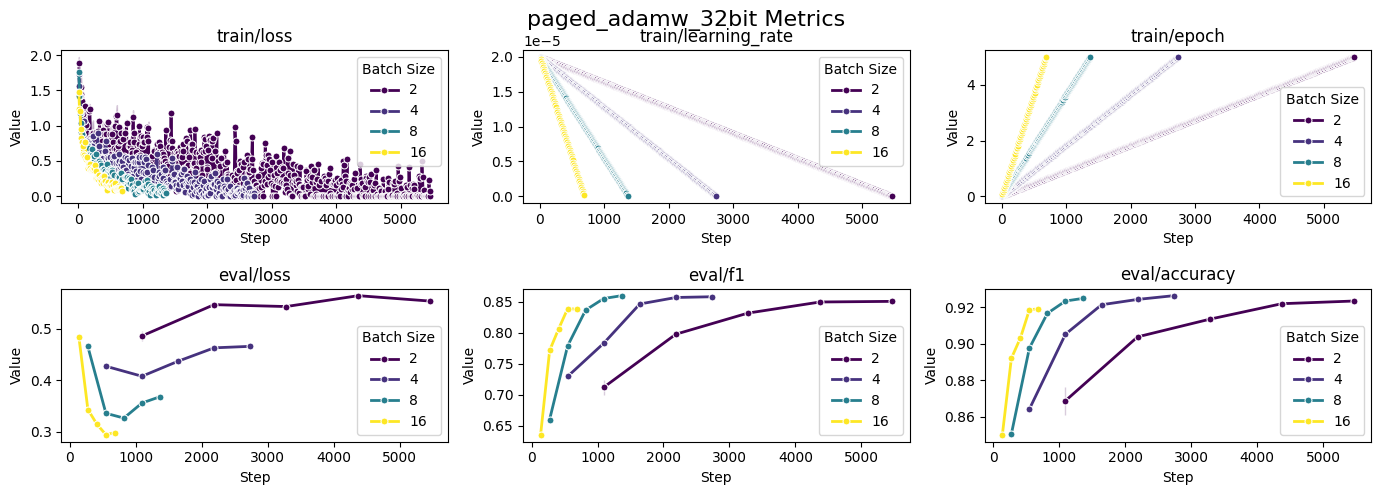

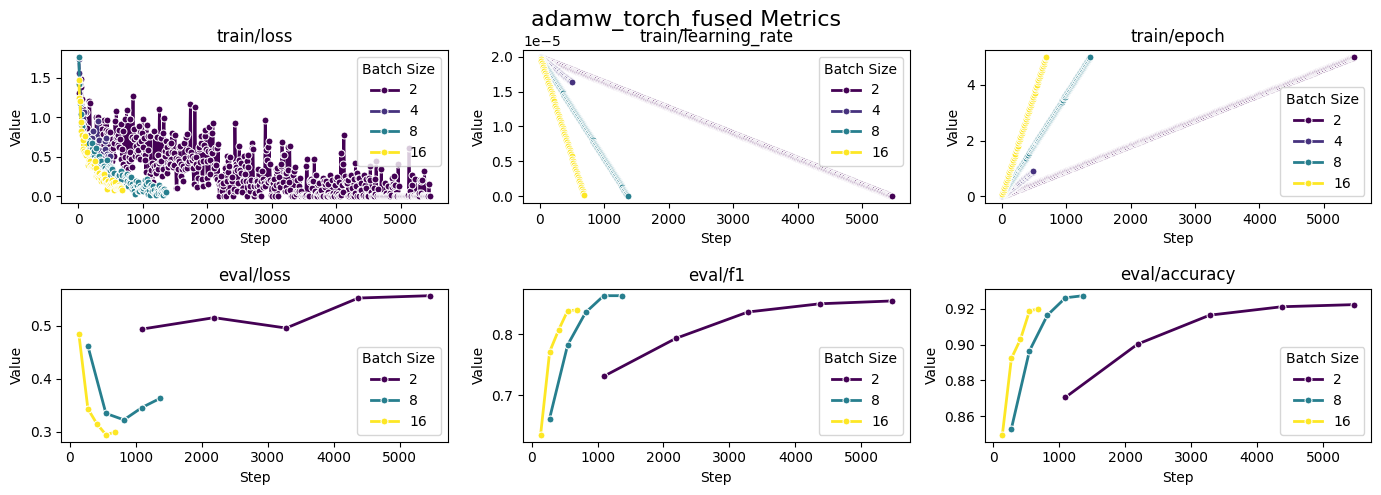

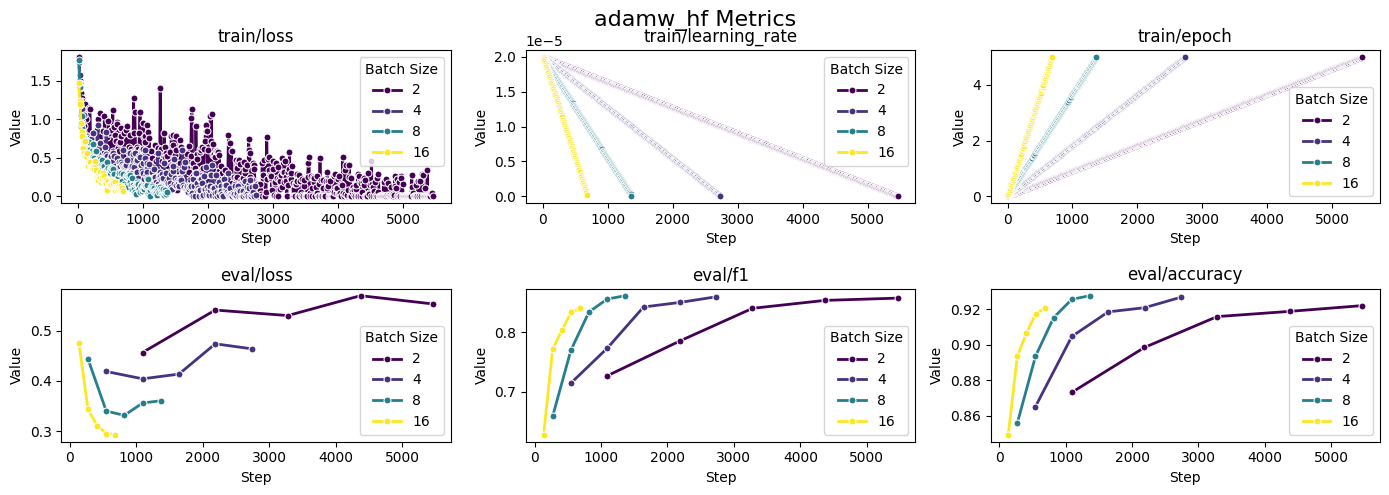

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1400x0 with 0 Axes>

In [6]:


metrics_to_drop = ['train/total_flos', 'train/train_loss', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second',
    'train/train_samples_per_second', 'train/train_steps_per_second', 'train/train_runtime']

top_3_models = df[df['metric'] == 'eval/f1'].sort_values(by='value', ascending=False).head(5)
top_3_model_names = top_3_models['optimizer'].unique()

df_filtered = df[~df['metric'].isin(metrics_to_drop)]
selected_rows = df_filtered[df_filtered['optimizer'].isin(top_3_model_names)]

for optimizer in df['optimizer'].unique():
    plot_optimizer(selected_rows, optimizer)


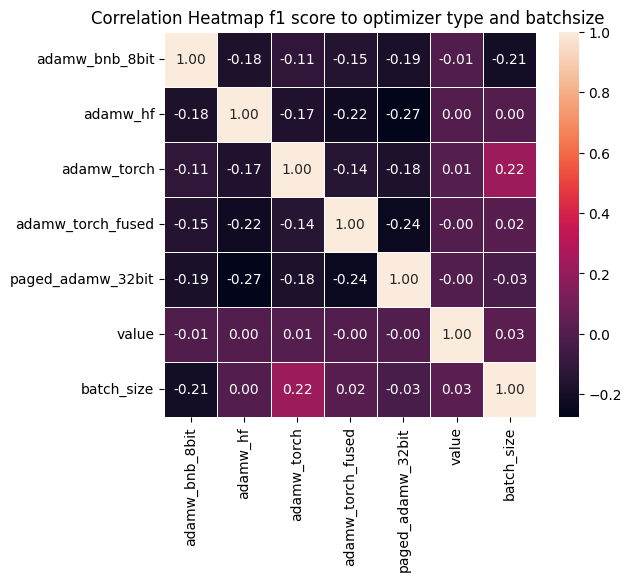

In [ ]:
optimizer_encoded = pd.get_dummies(df['optimizer'], drop_first=True)
data = pd.concat([optimizer_encoded, df[['value', 'batch_size']]], axis=1)
correlation_matrix = data.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='rocket', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap f1 score to optimizer type and batchsize ')
plt.show()